# ROB 498: Robot Learning for Planning and Control
# Assignment 3: Learning Dynamics Directly from State Measurements

## Colab Setup

In [1]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW3 folder, then 'ROB498/HW3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/ROB498/homeworks/HW3'

### Setup Code

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cd '/content/drive/MyDrive/Colab Notebooks/UMich-ROB-490/homeworks/HW3'

The below cell will check you have the required files in your directory. The file `mppi.py` will be released on 02/19/2023, so you should expect to see 'Required file `mppi.py` not found!' before then. This is because there may still be students working on Homework 2 until then. This file is not needed until Section 4 of the homework.

In [5]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw3.ipynb', 'learning_state_dynamics.py', 'panda_pushing_env.py', 'visualizers.py',  'mppi.py', 'validation_data.npy']

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

All required files are found :)


In [6]:
# Install missing required packages
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw

In [7]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

## Assignment Introduction

Due 3/8 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

# Planar Pushing Learning (100 points)
For this assignment we will train a robot to push an object to a goal pose.
To this end, you will have to collect dynamics data, process the data, train a model of the dynamics, and use it for planning a sequence of pushes to reach the target location.



## Simulation Environment Introduction

For our planar pushing setup, we will use PyBullet to simulate a panda robot that pushes a block on top of a table.
The pushing block is visualized in white. In green, we visualize the goal pose of the block.



In [8]:
from panda_pushing_env import PandaPushingEnv
from visualizers import GIFVisualizer, NotebookVisualizer

Run the following code block to visualize the robot pushing the block.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


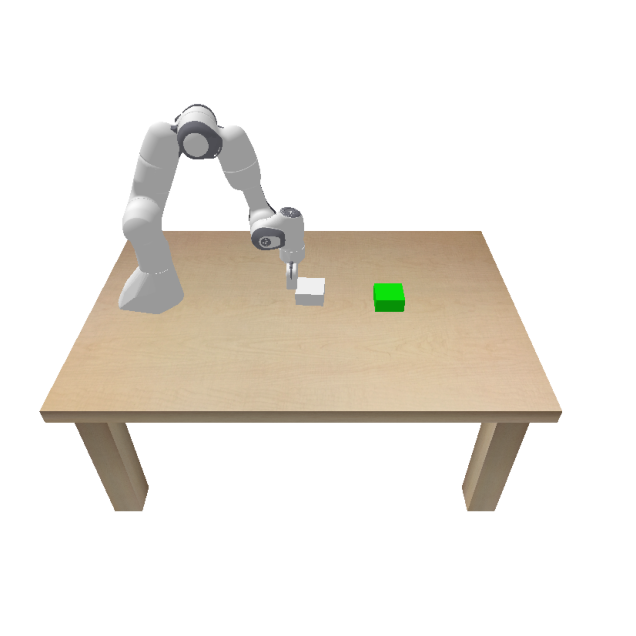

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=True,  camera_heigh=800, camera_width=800)
env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

plt.close(fig)

For speeding up the visualization, we will only visualize the pushing part of the robot motion. However, be aware of the full robot motion.

There is another option for visualization, which is to create a `.gif` file. The following cell shows an example of this. Note that here we set the rendering mode to just render the push motion for efficiency.

In [10]:
# Create the GIF visualizer
visualizer = GIFVisualizer()

# Initialize the simulation environment. This will only render push motions, omitting the robot reseting motions.
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False, camera_heigh=500, camera_width=500, render_every_n_steps=5)
env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(10)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

# Create and visualize the gif file.
Image(filename=visualizer.get_gif())



Output hidden; open in https://colab.research.google.com to view.

Rendering is useful for visualizing the implementation's performance and debugging. However, it consumes resources and takes time to produce. The following cell will perform 100 pushes without rendering. Compare the time with the previous rendering approaches. This should be an order of magnitude faster.

In [11]:
# Simulate pushing without rendering - this should take about 30s.
visualizer = None # No redering

env = PandaPushingEnv(visualizer=visualizer)
env.reset()

pbar =  tqdm(range(100)) # We will perform 100 pushes.

for i in pbar:
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        env.reset()


  0%|          | 0/100 [00:00<?, ?it/s]

### State Space and Action Space

For the planar pushing task, we have the following action and state spaces:

The image below illustrates the state space, which is the block planar location on top of the table.
$$
\mathbf x = \begin{bmatrix} x & y & \theta\end{bmatrix}^\top\in \text{SE}(2)
$$
Note that the state contains only position elements, and not velocity terms. This is because we assume that the pushing task is *quasi-static*. This means that the pushing actions are slow enough that the velocity and inertia of the block are negligible. In other words, if the robot stops pushing, the block also stops.


![State Space](https://drive.google.com/uc?export=view&id=1iuHwUC_IVsrBbgbyiR8qXDV4OBmgKObU)

Note that the robot is centered at the origin.


The following image show the robot action space.

![Action Space](https://drive.google.com/uc?export=view&id=1sFyNOAj-RmNbwk_Ww8VxmmkCaW4LpVZj)

Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-1,1]$: pushing location along the lower block edge.
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m



### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about the gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns
    1. `state`: The resulting state, i.e. $s_{t+1}$
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
Example:
```python
state, reward, done, info = env.step(action_i)
```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset.
Example:
```python
    state = env.reset()
```

Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space (block pose in $SE(2)$)
These are `gym.spaces` and therefore you can sample them using `.sample()`.
Example:
```python
action_i = env.action_space.sample()
```
This produces actions uniformly sampled from the action space.

You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).



## 1 - Collect Data  (15 points)

Given the environment, the first step is to collect data. The collected data will then be used to train a model of the pushing dynamics.

**TODO:**

* Implement `collect_data_random` in `learning_state_dynamics.py` which collects data trajectories. The actions should be uniformly random sampled within the action space limits.


**OBSERVATION**: Data collection may take some time. Please be patient and do not close the session while you are collecting data or the data collection process may be interrupted. Once the data is collected it will be saved, so if you restart the kernel you will not need to recollect the data.


**GRADING**: For grading you will also have to submit the saved collected data file `collected_data.npy`. We will check that the collected data is in the required format. However, we will NOT check the quality of the data. Note that for training a good model, data quality is key. Your collected data should be diverse to train an effective model of pushing dynamics.


In [12]:
# # Collect data (it may take some time)
# from learning_state_dynamics import collect_data_random

# # Data collection parameters
# N = 100 # Number of trajectories
# T = 10 # Trajectory length

# # Initialize the environment and collect data
# env = PandaPushingEnv()
# env.reset()
# collected_data = collect_data_random(env, num_trajectories=N, trajectory_length=T)


# # Verify the number of data collected:
# print(f'We have collected {len(collected_data)} trajectories')
# print('A data sample contains: ')
# for k, v in collected_data[0].items():
#     assert(type(v) == np.ndarray)
#     assert(v.dtype == np.float32)
#     print(f'\t {k}: numpy array of shape {v.shape}')

# # Save the collected data into a file
# np.save(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), collected_data)


In [13]:
# Load the collected data:
collected_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), allow_pickle=True)

## 2 - Data Processing (20 points)
Next, given the collected data you will have to process it so we can use it for training the model.


### 2.1 - Single Step Data (10 points)

Here we will process the data in a single-step format.


**TODO:**

* Implement `process_data_single_step` in `learning_state_dyanmics.py` to pack the collected data into a Dataset and returns a DataLoader for training and for validation.
You should do this via the following steps:
 1. Implement `SingleStepDynamicsDataset` which wraps the collected data into a PyTorch Dataset.
    * For this part you only need to implement the `__getitem__` method which returns the data $(\mathbf x_t, \mathbf u_t, \mathbf x_{t+1})$ as a dictionary
    * Your dataset should consist of all $(\mathbf x_t, \mathbf u_t, \mathbf x_{t+1})$ in the collected data
 2. You should instantiate your `SingleStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets.  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split.
 3. You should return a DataLoader for the training and validation set which loads batches of the data of the required `batch_size`.

In [14]:
# Process the data
from learning_state_dynamics import process_data_single_step, SingleStepDynamicsDataset

batch_size = 500
train_loader, val_loader = process_data_single_step(collected_data, batch_size=batch_size)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data -
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a SingleStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, SingleStepDynamicsDataset) else 'No')
print('')

# we should see the state, action and next state of shape (batch_size, 3)
for item in train_loader:
    print(f'state is shape {item["state"].shape}')
    print(f'action is shape {item["action"].shape}')
    print(f'next_state is shape {item["next_state"].shape}')
    break


Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([500, 3])
action is shape torch.Size([500, 3])
next_state is shape torch.Size([500, 3])


### 2.2 - Multi-step Data  (10 points)

Here we will process the data in a multi-step format.


**TODO:**

* Implement `process_data_multiple_step` in `learning_state_dyanmics.py` to pack the collected data into a Dataset and return a DataLoader for training and for validation.
You should do this via the following steps:
 1. Implement `MultiStepDynamicsDataset` which wraps the collected data into a PyTorch Dataset.
    * For this part you only need to implement the `__getitem__` method which returns $(\mathbf x_t, \mathbf u_t, ..., \mathbf u_{t+k-1}, \mathbf x_{t+1}, ... , \mathbf x_{t+k})$, where $k$ is `num_steps`. We will be using `num_steps=4`.
    * Your dataset should consist of all subtrajectories of the above form in the dataset. For instance, the trajectory $[(\mathbf x_1,\mathbf  u_1), (\mathbf x_2, \mathbf u_2), (\mathbf x_3, \mathbf u_3), (\mathbf x_4, \mathbf u_4), (\mathbf x_5, \mathbf u_5), (\mathbf x_6, \mathbf u_6), (\mathbf x_7)]$ should result in the following items in the dataset:
        - $(\mathbf x_1, \mathbf u_1, \mathbf u_2, \mathbf u_3, \mathbf u_4, \mathbf x_2, \mathbf x_3, \mathbf x_4, \mathbf x_5)$
        - $(\mathbf x_2, \mathbf u_2, \mathbf u_3, \mathbf u_4, \mathbf u_5, \mathbf x_3, \mathbf x_4, \mathbf x_5, \mathbf x_6)$
        - $(\mathbf x_3, \mathbf u_3, \mathbf u_4, \mathbf u_5, \mathbf u_6, \mathbf x_4, \mathbf x_5, \mathbf x_6, \mathbf x_7)$
 2. You should instantiate your `MultiStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split.
 3. You should return a DataLoader for the training and validation set which loads batched of the data of the required `batch_size`.

In [15]:
# Process the data
from learning_state_dynamics import process_data_multiple_step, MultiStepDynamicsDataset


train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data -
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a MultiStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, MultiStepDynamicsDataset) else 'No')
print('')

# we should see the state is shape (batch_size, 3)
# and action, next_state are shape (batch_size, num_steps, 3)
for item in train_loader:
    print(f'state is shape {item["state"].shape}')
    print(f'action is shape {item["action"].shape}')
    print(f'next_state is shape {item["next_state"].shape}')
    break

Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([500, 3])
action is shape torch.Size([500, 4, 3])
next_state is shape torch.Size([500, 4, 3])


## 3 - Learn the Pushing Dynamics (35 points)
In this part, we will train a Neural Network (NN) to model the pushing dynamics. We will formulate two approaches, absolute dynamics and residual dynamics, and compare them.

You should use the training data and validation data you collected above to train this model. We have also provided a set of validation data to you in the file `validation_data.npy`. Cells for section 3.3 and 3.5 will evaluate your model with this validation data. If you find you are getting low loss on your collected data, but performing poorly on the validation data we provide, then one possibility is that your `collect_data_random` function from section 1 is not collecting a useful dataset.


In [16]:
from learning_state_dynamics import AbsoluteDynamicsModel, ResidualDynamicsModel, SE2PoseLoss, SingleStepLoss

### 3.1 - Absolute Dynamics Learning (20 points)
Given the collected data triplets $(\mathbf x_{t} , \mathbf u_{t}, \mathbf x_{t+1})$ we will learn to predict the state transition dynamics

$$\hat{\mathbf x}_{t+1} = f(\mathbf x_{t} , \mathbf u_{t}) $$

**TODO:**

1. In `learning_state_dynamics.py` implement `AbsoluteDynamicsModel`.
    * The model architecture will be a 3 linear layer NN with hidden sizes of 100 and ReLU activations.
2. Implement `SE2PoseLoss` in `learning_state_dynamics.py` to compute the loss of a $SE(2)$ state.
    * Its `forward` method computes the loss between two batched sets of $SE(2)$ transformations.
    * SE(2) vectors contain two position elements and one orientation element, i.e. $\mathbf q = \begin{bmatrix}x & y & \theta\end{bmatrix}^\top \in SE(2)$
    * To combine the different dimensions of pose and orientation, here we will exploit the fact that we know the object geometry. The error in orientation can be converted to error in position using the *radius of gyration* [https://en.wikipedia.org/wiki/Radius_of_gyration]. Since the object is a rectangle of width $w$ and length $l$, the radius of gyration is:
    $$
    r_g = \sqrt{\frac{w^2 + l^2}{12}}
    $$

    Therefore, to compare two poses  $\mathbf q_1 = \begin{bmatrix}x_1 & y_1 & \theta_1\end{bmatrix}^\top, \mathbf q_2 = \begin{bmatrix}x_2 & y_2 & \theta_2\end{bmatrix}^\top, \mathbf q_1, \mathbf q_2 \in SE(2)$ , we can do so as:

    $$
    \mathcal L(\mathbf q_1, \mathbf q_2) = \text{MSE}(x_1, x_2) + \text{MSE}(y_1, y_2) + r_g \text{MSE}(\theta_1, \theta_2)
    $$
    $$
    \\
    $$

3. Implement `SingleStepLoss.forward` in `learning_state_dynamics.py`. This method will perform a prediction with the model and computes the loss using the above loss function.
3. Train the model and save it as `pushing_absolute_dynamics_model.pt`. You will also have to submit this file.

HINT:
* You can reuse code from HW1 for training and evaluation of the models - you may need to make some slight modifications
* You should expect to see training and validation losses on your collected dataset on the order of $5 \times 10^{-4}$

In [17]:
# Train the dynamics model
pushing_absolute_dynamics_model = AbsoluteDynamicsModel(3,3)

train_loader, val_loader = process_data_single_step(collected_data)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# --- Your code here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pushing_absolute_dynamics_model.to(device)

optimizer = optim.Adam(pushing_absolute_dynamics_model.parameters(), lr=0.001)

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  running_loss = 0.0
  for sample in tqdm(train_loader, desc='training', leave=False):
    state = sample['state'].to(device)
    action = sample['action'].to(device)
    next_state = sample['next_state'].to(device)

    optimizer.zero_grad()

    train_loss = pose_loss(pushing_absolute_dynamics_model,state,action,next_state)

    train_loss.backward()

    optimizer.step()

    running_loss += train_loss.item()

    # Print the average loss for the epoch
  epoch_loss = running_loss / len(train_loader)
  print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

  pushing_absolute_dynamics_model.eval()
  with torch.no_grad():
      val_loss = 0.0
      for sample in val_loader:
          state = sample['state'].to(device)
          action = sample['action'].to(device)
          next_state = sample['next_state'].to(device)

          valid_loss = pose_loss(pushing_absolute_dynamics_model,state,action,next_state)

          val_loss += valid_loss.item()

      val_loss /= len(val_loader)
      print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss}")

  pushing_absolute_dynamics_model.train()  # Set the model back to training mode

# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_absolute_dynamics_model.pt')
torch.save(pushing_absolute_dynamics_model.state_dict(), save_path)



  0%|          | 0/100 [00:00<?, ?it/s]

training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.3975173979997635
Epoch [1/100], Validation Loss: 0.3076624870300293


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/100], Loss: 0.2748408615589142
Epoch [2/100], Validation Loss: 0.20454448461532593


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/100], Loss: 0.17808832973241806
Epoch [3/100], Validation Loss: 0.12620718777179718


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/100], Loss: 0.10691317543387413
Epoch [4/100], Validation Loss: 0.07313188165426254


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/100], Loss: 0.06283443048596382
Epoch [5/100], Validation Loss: 0.0460418164730072


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/100], Loss: 0.042639363557100296
Epoch [6/100], Validation Loss: 0.04207494109869003


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/100], Loss: 0.04477635398507118
Epoch [7/100], Validation Loss: 0.0492628812789917


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/100], Loss: 0.05317176505923271
Epoch [8/100], Validation Loss: 0.05329330265522003


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/100], Loss: 0.054862139746546745
Epoch [9/100], Validation Loss: 0.04951667785644531


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.04824721999466419
Epoch [10/100], Validation Loss: 0.040974896401166916


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/100], Loss: 0.03873017057776451
Epoch [11/100], Validation Loss: 0.03215961530804634


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/100], Loss: 0.030023212544620037
Epoch [12/100], Validation Loss: 0.026255063712596893


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/100], Loss: 0.024275196716189384
Epoch [13/100], Validation Loss: 0.023953083902597427


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/100], Loss: 0.022279851138591766
Epoch [14/100], Validation Loss: 0.024055805057287216


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/100], Loss: 0.021970225498080254
Epoch [15/100], Validation Loss: 0.02470860444009304


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/100], Loss: 0.022448896430432796
Epoch [16/100], Validation Loss: 0.024817271158099174


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/100], Loss: 0.022538145072758198
Epoch [17/100], Validation Loss: 0.024104401469230652


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/100], Loss: 0.021164067089557648
Epoch [18/100], Validation Loss: 0.022725719958543777


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/100], Loss: 0.020004067569971085
Epoch [19/100], Validation Loss: 0.020976824685931206


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.018345056101679802
Epoch [20/100], Validation Loss: 0.019245635718107224


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/100], Loss: 0.01686201523989439
Epoch [21/100], Validation Loss: 0.018003026023507118


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/100], Loss: 0.016272710636258125
Epoch [22/100], Validation Loss: 0.017412438988685608


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/100], Loss: 0.015838184393942356
Epoch [23/100], Validation Loss: 0.017204416915774345


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/100], Loss: 0.01570285949856043
Epoch [24/100], Validation Loss: 0.01691984012722969


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/100], Loss: 0.015516351908445358
Epoch [25/100], Validation Loss: 0.016415756195783615


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [26/100], Loss: 0.015015362296253443
Epoch [26/100], Validation Loss: 0.015799015760421753


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [27/100], Loss: 0.014408662915229797
Epoch [27/100], Validation Loss: 0.015243630856275558


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [28/100], Loss: 0.013614420779049397
Epoch [28/100], Validation Loss: 0.014793843030929565


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [29/100], Loss: 0.01299778651446104
Epoch [29/100], Validation Loss: 0.014450736343860626


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [30/100], Loss: 0.012778381817042828
Epoch [30/100], Validation Loss: 0.014183120802044868


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [31/100], Loss: 0.012506328988820314
Epoch [31/100], Validation Loss: 0.01385748665779829


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [32/100], Loss: 0.0123767857439816
Epoch [32/100], Validation Loss: 0.013442297466099262


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [33/100], Loss: 0.01177408080548048
Epoch [33/100], Validation Loss: 0.012974509969353676


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [34/100], Loss: 0.011355066206306219
Epoch [34/100], Validation Loss: 0.012534340843558311


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [35/100], Loss: 0.010760676581412554
Epoch [35/100], Validation Loss: 0.012134581804275513


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [36/100], Loss: 0.010649693198502064
Epoch [36/100], Validation Loss: 0.01176447980105877


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [37/100], Loss: 0.01045061880722642
Epoch [37/100], Validation Loss: 0.011415842920541763


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [38/100], Loss: 0.010096643585711718
Epoch [38/100], Validation Loss: 0.011078999377787113


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [39/100], Loss: 0.009802893735468388
Epoch [39/100], Validation Loss: 0.0107567785307765


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [40/100], Loss: 0.009495890233665705
Epoch [40/100], Validation Loss: 0.010464118793606758


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [41/100], Loss: 0.009156917687505484
Epoch [41/100], Validation Loss: 0.010213056579232216


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [42/100], Loss: 0.008894484024494886
Epoch [42/100], Validation Loss: 0.009957786649465561


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [43/100], Loss: 0.008512561209499836
Epoch [43/100], Validation Loss: 0.009688871912658215


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [44/100], Loss: 0.008337732404470444
Epoch [44/100], Validation Loss: 0.009396718814969063


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [45/100], Loss: 0.008187554311007261
Epoch [45/100], Validation Loss: 0.009111931547522545


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [46/100], Loss: 0.007900514174252748
Epoch [46/100], Validation Loss: 0.008849777281284332


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [47/100], Loss: 0.007674506399780512
Epoch [47/100], Validation Loss: 0.008605706505477428


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [48/100], Loss: 0.007485644659027457
Epoch [48/100], Validation Loss: 0.008379507809877396


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [49/100], Loss: 0.0072635565884411335
Epoch [49/100], Validation Loss: 0.008169909007847309


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [50/100], Loss: 0.006987866014242172
Epoch [50/100], Validation Loss: 0.007970105856657028


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [51/100], Loss: 0.006821728078648448
Epoch [51/100], Validation Loss: 0.007780949119478464


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [52/100], Loss: 0.006661468185484409
Epoch [52/100], Validation Loss: 0.007607732899487019


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [53/100], Loss: 0.006415178533643484
Epoch [53/100], Validation Loss: 0.007435981184244156


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [54/100], Loss: 0.00628378102555871
Epoch [54/100], Validation Loss: 0.0072768270038068295


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [55/100], Loss: 0.006085371132940054
Epoch [55/100], Validation Loss: 0.00713356863707304


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [56/100], Loss: 0.006005323491990566
Epoch [56/100], Validation Loss: 0.006976220291107893


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [57/100], Loss: 0.005884665763005614
Epoch [57/100], Validation Loss: 0.006831335835158825


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [58/100], Loss: 0.005694083636626601
Epoch [58/100], Validation Loss: 0.00670371949672699


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [59/100], Loss: 0.00553774693980813
Epoch [59/100], Validation Loss: 0.0065934197045862675


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [60/100], Loss: 0.005395202664658427
Epoch [60/100], Validation Loss: 0.006483207456767559


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [61/100], Loss: 0.005318480543792248
Epoch [61/100], Validation Loss: 0.006364732515066862


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [62/100], Loss: 0.00522176967933774
Epoch [62/100], Validation Loss: 0.006253046914935112


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [63/100], Loss: 0.005220709135755897
Epoch [63/100], Validation Loss: 0.006153894122689962


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [64/100], Loss: 0.005088998470455408
Epoch [64/100], Validation Loss: 0.006055059842765331


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [65/100], Loss: 0.00497284228913486
Epoch [65/100], Validation Loss: 0.005958687514066696


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [66/100], Loss: 0.00487330392934382
Epoch [66/100], Validation Loss: 0.005863686092197895


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [67/100], Loss: 0.0048563063610345125
Epoch [67/100], Validation Loss: 0.0057733748108148575


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [68/100], Loss: 0.004712545080110431
Epoch [68/100], Validation Loss: 0.005690128076821566


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [69/100], Loss: 0.004622661275789142
Epoch [69/100], Validation Loss: 0.0055962516926229


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [70/100], Loss: 0.0046732621267437935
Epoch [70/100], Validation Loss: 0.005508406553417444


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [71/100], Loss: 0.004417124204337597
Epoch [71/100], Validation Loss: 0.005430441349744797


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [72/100], Loss: 0.004448800580576062
Epoch [72/100], Validation Loss: 0.0053757186979055405


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [73/100], Loss: 0.004367407411336899
Epoch [73/100], Validation Loss: 0.005308210849761963


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [74/100], Loss: 0.004263401031494141
Epoch [74/100], Validation Loss: 0.00521524902433157


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [75/100], Loss: 0.0042573269456624985
Epoch [75/100], Validation Loss: 0.005121977534145117


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [76/100], Loss: 0.0041354065760970116
Epoch [76/100], Validation Loss: 0.005032008979469538


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [77/100], Loss: 0.004033456090837717
Epoch [77/100], Validation Loss: 0.004960437770932913


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [78/100], Loss: 0.00400572782382369
Epoch [78/100], Validation Loss: 0.0048934719525277615


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [79/100], Loss: 0.0040010144002735615
Epoch [79/100], Validation Loss: 0.004829434212297201


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [80/100], Loss: 0.003919694456271827
Epoch [80/100], Validation Loss: 0.004755157046020031


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [81/100], Loss: 0.00383628043346107
Epoch [81/100], Validation Loss: 0.004678841680288315


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [82/100], Loss: 0.003742253757081926
Epoch [82/100], Validation Loss: 0.004614909645169973


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [83/100], Loss: 0.003729729214683175
Epoch [83/100], Validation Loss: 0.004562694579362869


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [84/100], Loss: 0.0036665446823462844
Epoch [84/100], Validation Loss: 0.004502971190959215


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [85/100], Loss: 0.0035356103908270597
Epoch [85/100], Validation Loss: 0.004436006303876638


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [86/100], Loss: 0.003506281995214522
Epoch [86/100], Validation Loss: 0.004361088387668133


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [87/100], Loss: 0.003463221248239279
Epoch [87/100], Validation Loss: 0.00428610946983099


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [88/100], Loss: 0.003403826616704464
Epoch [88/100], Validation Loss: 0.004222729708999395


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [89/100], Loss: 0.003351727733388543
Epoch [89/100], Validation Loss: 0.004173307213932276


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [90/100], Loss: 0.0032847432885318995
Epoch [90/100], Validation Loss: 0.00412485608831048


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [91/100], Loss: 0.0032885592663660645
Epoch [91/100], Validation Loss: 0.004047896713018417


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [92/100], Loss: 0.003218617755919695
Epoch [92/100], Validation Loss: 0.003980168607085943


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [93/100], Loss: 0.003100598114542663
Epoch [93/100], Validation Loss: 0.003923231735825539


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [94/100], Loss: 0.003066728007979691
Epoch [94/100], Validation Loss: 0.003876117989420891


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [95/100], Loss: 0.0030562503961846232
Epoch [95/100], Validation Loss: 0.0038191964849829674


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [96/100], Loss: 0.0029698621947318316
Epoch [96/100], Validation Loss: 0.0037538735195994377


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [97/100], Loss: 0.0028861762257292867
Epoch [97/100], Validation Loss: 0.003693921957165003


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [98/100], Loss: 0.00291029189247638
Epoch [98/100], Validation Loss: 0.0036374242044985294


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [99/100], Loss: 0.0028154923347756267
Epoch [99/100], Validation Loss: 0.0035735517740249634


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [100/100], Loss: 0.002773256041109562
Epoch [100/100], Validation Loss: 0.0035085834097117186


### 3.2 - Residual Dynamics Learning (10 points)
Given the collected data triplets $(\mathbf x_{t} , \mathbf u_{t}, \mathbf x_{t+1})$ we will learn to predict the state transition dynamics

$$\hat{\mathbf x}_{t+1} = \mathbf x_{t} + \Delta \mathbf x_{t} =  \mathbf x_{t} + f(\mathbf x_{t}, \mathbf u_{t}) $$


**TODO:**

1. In `learning_state_dynamics.py` implement `ResidualDynamicsModel`.
    * Its `forward` method should compute $\hat{\mathbf x}_{t+1}$ . Here, the network will output $\Delta \mathbf x_{t}$, which will need to be added to $\mathbf x_t$ to obtain $\hat{\mathbf x}_{t+1}$
    * The model architecture will be a 3 linear layer NN with hidden sizes of 100 and ReLU activations.
2. Train the model and save it as `pushing_residual_dynamics_model.pt`. You will also have to submit this file.

HINT:
* Similar to above, you should expect to see training and validation losses on your collected dataset on the order of $5 \times 10^{-4}$.

In [18]:
pushing_residual_dynamics_model = ResidualDynamicsModel(3,3)
train_loader, val_loader = process_data_single_step(collected_data)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# --- Your code here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pushing_residual_dynamics_model.to(device)

optimizer = optim.Adam(pushing_residual_dynamics_model.parameters(), lr=0.001)

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  running_loss = 0.0
  for sample in tqdm(train_loader, desc='training', leave=False):
    state = sample['state'].to(device)
    action = sample['action'].to(device)
    next_state = sample['next_state'].to(device)

    optimizer.zero_grad()

    loss = pose_loss(pushing_residual_dynamics_model,state,action,next_state)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    # Print the average loss for the epoch
  epoch_loss = running_loss / len(train_loader)

  pushing_residual_dynamics_model.eval()
  with torch.no_grad():
      val_loss = 0.0
      for sample in val_loader:
          state = sample['state'].to(device)
          action = sample['action'].to(device)
          next_state = sample['next_state'].to(device)

          valid_loss = pose_loss(pushing_residual_dynamics_model,state,action,next_state)

          val_loss += valid_loss.item()

      val_loss /= len(val_loader)
      print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss}  ||   Validation Loss: {val_loss}")

  pushing_residual_dynamics_model.train()  # Set the model back to training mode

# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_residual_dynamics_model.pt')
torch.save(pushing_residual_dynamics_model.state_dict(), save_path)

  0%|          | 0/100 [00:00<?, ?it/s]

training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 0.008343113586306572  ||   Validation Loss: 0.004842374473810196


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/100], Training Loss: 0.00527307647280395  ||   Validation Loss: 0.004952240735292435


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/100], Training Loss: 0.0045026433654129505  ||   Validation Loss: 0.002944663865491748


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/100], Training Loss: 0.002933094510808587  ||   Validation Loss: 0.002464807126671076


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/100], Training Loss: 0.0029096700018271804  ||   Validation Loss: 0.0026589890476316214


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/100], Training Loss: 0.0029548429884016514  ||   Validation Loss: 0.0021027340553700924


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/100], Training Loss: 0.002237968728877604  ||   Validation Loss: 0.0017557491082698107


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/100], Training Loss: 0.001962224254384637  ||   Validation Loss: 0.0020008685532957315


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/100], Training Loss: 0.0020975806983187795  ||   Validation Loss: 0.0018593836575746536


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/100], Training Loss: 0.0018721004016697407  ||   Validation Loss: 0.0013847083318978548


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/100], Training Loss: 0.0015322387334890664  ||   Validation Loss: 0.001255321316421032


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/100], Training Loss: 0.001486234541516751  ||   Validation Loss: 0.0013155920896679163


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/100], Training Loss: 0.0014576644753105938  ||   Validation Loss: 0.0012051597004756331


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/100], Training Loss: 0.0013353988179005682  ||   Validation Loss: 0.0011235858546569943


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/100], Training Loss: 0.00121824856614694  ||   Validation Loss: 0.0011369192507117987


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/100], Training Loss: 0.0012362322304397821  ||   Validation Loss: 0.0010659933323040605


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/100], Training Loss: 0.0011414694017730653  ||   Validation Loss: 0.0009732783655636013


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/100], Training Loss: 0.0010803648619912565  ||   Validation Loss: 0.0009655555477365851


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/100], Training Loss: 0.0010728815686888993  ||   Validation Loss: 0.0009482132736593485


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/100], Training Loss: 0.0010364946792833507  ||   Validation Loss: 0.0008913148776628077


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/100], Training Loss: 0.0009864049789030105  ||   Validation Loss: 0.0008803438395261765


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/100], Training Loss: 0.000968035077676177  ||   Validation Loss: 0.0008897961815819144


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/100], Training Loss: 0.000946517800912261  ||   Validation Loss: 0.0008618108695372939


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/100], Training Loss: 0.0009212822187691927  ||   Validation Loss: 0.000841740402393043


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/100], Training Loss: 0.0008805936959106475  ||   Validation Loss: 0.0008314565639011562


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [26/100], Training Loss: 0.0008603018068242818  ||   Validation Loss: 0.0008123674779199064


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [27/100], Training Loss: 0.000836777500808239  ||   Validation Loss: 0.0008022785186767578


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [28/100], Training Loss: 0.0008319400367327034  ||   Validation Loss: 0.0007904216181486845


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [29/100], Training Loss: 0.0008125379681587219  ||   Validation Loss: 0.0007710101781412959


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [30/100], Training Loss: 0.0007735205290373415  ||   Validation Loss: 0.0007603911217302084


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [31/100], Training Loss: 0.0007671480998396873  ||   Validation Loss: 0.0007516562473028898


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [32/100], Training Loss: 0.0007658510294277221  ||   Validation Loss: 0.0007360141025856137


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [33/100], Training Loss: 0.0007491798023693264  ||   Validation Loss: 0.0007239282131195068


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [34/100], Training Loss: 0.0007285651518031955  ||   Validation Loss: 0.0007086601108312607


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [35/100], Training Loss: 0.0007474978629034013  ||   Validation Loss: 0.0006916944985277951


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [36/100], Training Loss: 0.0006993256974965334  ||   Validation Loss: 0.000675161019898951


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [37/100], Training Loss: 0.0006902744644321501  ||   Validation Loss: 0.0006603133515454829


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [38/100], Training Loss: 0.0006806843157391995  ||   Validation Loss: 0.0006496686255559325


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [39/100], Training Loss: 0.0006609140255022794  ||   Validation Loss: 0.0006416392861865461


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [40/100], Training Loss: 0.0006544611242134124  ||   Validation Loss: 0.0006266431300900877


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [41/100], Training Loss: 0.0006280166853684932  ||   Validation Loss: 0.0006116111180745065


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [42/100], Training Loss: 0.0006271868478506804  ||   Validation Loss: 0.0006004967726767063


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [43/100], Training Loss: 0.0006031155935488641  ||   Validation Loss: 0.000592358352150768


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [44/100], Training Loss: 0.000590676732826978  ||   Validation Loss: 0.0005819734069518745


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [45/100], Training Loss: 0.0005810780276078731  ||   Validation Loss: 0.0005694804713129997


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [46/100], Training Loss: 0.0005724460643250495  ||   Validation Loss: 0.0005603560130111873


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [47/100], Training Loss: 0.0005772584991063923  ||   Validation Loss: 0.0005515728844329715


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [48/100], Training Loss: 0.0005562601145356894  ||   Validation Loss: 0.0005406240816228092


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [49/100], Training Loss: 0.0005428840813692659  ||   Validation Loss: 0.0005303185316734016


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [50/100], Training Loss: 0.0005250174144748598  ||   Validation Loss: 0.0005198771832510829


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [51/100], Training Loss: 0.0005035325011704117  ||   Validation Loss: 0.0005093833315186203


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [52/100], Training Loss: 0.0004955968470312655  ||   Validation Loss: 0.0004992116009816527


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [53/100], Training Loss: 0.00047698804701212794  ||   Validation Loss: 0.0004888026742264628


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [54/100], Training Loss: 0.0004754287365358323  ||   Validation Loss: 0.0004799236194230616


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [55/100], Training Loss: 0.0004662217979785055  ||   Validation Loss: 0.0004687652108259499


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [56/100], Training Loss: 0.0004460134805412963  ||   Validation Loss: 0.0004593158373609185


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [57/100], Training Loss: 0.0004337458376539871  ||   Validation Loss: 0.00045193894766271114


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [58/100], Training Loss: 0.0004461024218471721  ||   Validation Loss: 0.00044313084799796343


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [59/100], Training Loss: 0.00042019871762022376  ||   Validation Loss: 0.0004338290891610086


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [60/100], Training Loss: 0.00040364185406360775  ||   Validation Loss: 0.00042609008960425854


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [61/100], Training Loss: 0.000409001178923063  ||   Validation Loss: 0.0004189584869891405


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [62/100], Training Loss: 0.00038721405144315213  ||   Validation Loss: 0.0004089720896445215


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [63/100], Training Loss: 0.0003809814515989274  ||   Validation Loss: 0.0004015709273517132


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [64/100], Training Loss: 0.0003669166035251692  ||   Validation Loss: 0.00039504157030023634


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [65/100], Training Loss: 0.00036300804640632123  ||   Validation Loss: 0.0003869279462378472


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [66/100], Training Loss: 0.0003520091268001124  ||   Validation Loss: 0.00038010813295841217


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [67/100], Training Loss: 0.00034318053803872317  ||   Validation Loss: 0.00037408771459013224


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [68/100], Training Loss: 0.00033374069607816637  ||   Validation Loss: 0.00036587423528544605


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [69/100], Training Loss: 0.0003294662747066468  ||   Validation Loss: 0.00035922869574278593


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [70/100], Training Loss: 0.0003166952374158427  ||   Validation Loss: 0.0003533242561388761


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [71/100], Training Loss: 0.0003057303110836074  ||   Validation Loss: 0.00034649152075871825


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [72/100], Training Loss: 0.0003078370064031333  ||   Validation Loss: 0.0003409433993510902


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [73/100], Training Loss: 0.0002983483427669853  ||   Validation Loss: 0.00033569952938705683


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [74/100], Training Loss: 0.0002883956040022895  ||   Validation Loss: 0.00032976758666336536


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [75/100], Training Loss: 0.0002821685338858515  ||   Validation Loss: 0.0003246031701564789


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [76/100], Training Loss: 0.00026979795075021684  ||   Validation Loss: 0.0003211833827663213


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [77/100], Training Loss: 0.00027583107294049114  ||   Validation Loss: 0.00031474680872634053


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [78/100], Training Loss: 0.00026650149084161967  ||   Validation Loss: 0.000308664923068136


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [79/100], Training Loss: 0.0002575762919150293  ||   Validation Loss: 0.0003048037178814411


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [80/100], Training Loss: 0.0002544104208936915  ||   Validation Loss: 0.0003014998510479927


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [81/100], Training Loss: 0.0002443705525365658  ||   Validation Loss: 0.0002975640236400068


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [82/100], Training Loss: 0.00023812729341443628  ||   Validation Loss: 0.0002934558433480561


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [83/100], Training Loss: 0.0002321694846614264  ||   Validation Loss: 0.0002903688291553408


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [84/100], Training Loss: 0.0002235441279481165  ||   Validation Loss: 0.00028735437081195414


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [85/100], Training Loss: 0.00022188093862496316  ||   Validation Loss: 0.00028391534578986466


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [86/100], Training Loss: 0.00021651740826200694  ||   Validation Loss: 0.0002810463192872703


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [87/100], Training Loss: 0.00021306017879396677  ||   Validation Loss: 0.0002779874484986067


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [88/100], Training Loss: 0.00020531518384814262  ||   Validation Loss: 0.0002749293053057045


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [89/100], Training Loss: 0.00020102437702007592  ||   Validation Loss: 0.00027316040359437466


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [90/100], Training Loss: 0.00019878555758623406  ||   Validation Loss: 0.0002693230053409934


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [91/100], Training Loss: 0.0001995143320527859  ||   Validation Loss: 0.00026735287974588573


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [92/100], Training Loss: 0.00019529843848431483  ||   Validation Loss: 0.00026596509269438684


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [93/100], Training Loss: 0.0001909526763483882  ||   Validation Loss: 0.0002622980682644993


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [94/100], Training Loss: 0.00018440962594468147  ||   Validation Loss: 0.0002603086759336293


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [95/100], Training Loss: 0.00018313674809178337  ||   Validation Loss: 0.00026043926482088864


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [96/100], Training Loss: 0.00018012758664553985  ||   Validation Loss: 0.00025685486616566777


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [97/100], Training Loss: 0.0001797621007426642  ||   Validation Loss: 0.000254542741458863


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [98/100], Training Loss: 0.00017447927530156448  ||   Validation Loss: 0.0002545872121118009


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [99/100], Training Loss: 0.00017029788432409987  ||   Validation Loss: 0.000250078592216596


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [100/100], Training Loss: 0.00016620860697003081  ||   Validation Loss: 0.0002480381808709353


### 3.3 - Absolute Dynamics vs Residual Dynamics (No points)
In this section we will compare the performance of the absolute dynamics model and the residual dynamics model with test data that we provide you.

Which one performs better? Why is that the case?

You should see both losses be below $5 \times 10^{-4}$

In [19]:
cd /content/drive/MyDrive/Colab Notebooks/UMich-ROB-490/homeworks/HW3/

/content/drive/MyDrive/Colab Notebooks/UMich-ROB-490/homeworks/HW3


In [20]:
val_dataset = SingleStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

loss_absolute = 0.0
loss_residual = 0.0

for item in val_loader:
    loss_absolute += pose_loss(pushing_absolute_dynamics_model, item['state'], item['action'], item['next_state'])
    loss_residual += pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

print(f'Validation loss for absolute dynamics model is {loss_absolute}')
print(f'Validation loss for residual dynamics model is {loss_residual}')

Validation loss for absolute dynamics model is 0.003430080832913518
Validation loss for residual dynamics model is 0.0002526718017179519


### 3.4 Multi-step Loss (10 points)

In this section you will train a residual dynamics model using a recursive multistep loss, as shown in the lectures.

**TODO**:
Implement `MultiStepLoss` in `learning_state_dynamics.py`
* The parameter `discount` is the same as $\lambda$ from the lectures.
* HINT: You may need to reduce the learning rate and train for slightly longer for the multi-step loss

In [21]:
# Train the dynamics model
from learning_state_dynamics import MultiStepLoss, process_data_multiple_step
pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = MultiStepLoss(pose_loss, discount=0.9)

# --- Your code here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pushing_multistep_residual_dynamics_model.to(device)

optimizer = optim.Adam(pushing_multistep_residual_dynamics_model.parameters(), lr=0.001)

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  running_loss = 0.0
  for sample in tqdm(train_loader, desc='training', leave=False):
    state = sample['state'].to(device)
    action = sample['action'].to(device)
    next_state = sample['next_state'].to(device)

    optimizer.zero_grad()

    loss = pose_loss(pushing_multistep_residual_dynamics_model,state,action,next_state)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    # Print the average loss for the epoch
  epoch_loss = running_loss / len(train_loader)

  pushing_multistep_residual_dynamics_model.eval()
  with torch.no_grad():
      val_loss = 0.0
      for sample in val_loader:
          state = sample['state'].to(device)
          action = sample['action'].to(device)
          next_state = sample['next_state'].to(device)

          valid_loss = pose_loss(pushing_multistep_residual_dynamics_model,state,action,next_state)

          val_loss += valid_loss.item()

      val_loss /= len(val_loader)
      print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss}  ||   Validation Loss: {val_loss}")

  pushing_multistep_residual_dynamics_model.train()  # Set the model back to training mode



# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_multi_step_residual_dynamics_model.pt')
torch.save(pushing_multistep_residual_dynamics_model.state_dict(), save_path)

  0%|          | 0/100 [00:00<?, ?it/s]

training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/100], Training Loss: 0.5725059062242508  ||   Validation Loss: 0.08788406848907471


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/100], Training Loss: 0.06600300595164299  ||   Validation Loss: 0.10492052882909775


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/100], Training Loss: 0.13846461474895477  ||   Validation Loss: 0.20914658904075623


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/100], Training Loss: 0.1931712031364441  ||   Validation Loss: 0.12877991795539856


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/100], Training Loss: 0.0990714579820633  ||   Validation Loss: 0.03750251978635788


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/100], Training Loss: 0.02718161139637232  ||   Validation Loss: 0.024256065487861633


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/100], Training Loss: 0.03156141843646765  ||   Validation Loss: 0.054451920092105865


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/100], Training Loss: 0.058673568069934845  ||   Validation Loss: 0.06861931830644608


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/100], Training Loss: 0.06788205727934837  ||   Validation Loss: 0.05113312602043152


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/100], Training Loss: 0.04232000559568405  ||   Validation Loss: 0.025711633265018463


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/100], Training Loss: 0.019903280306607485  ||   Validation Loss: 0.016881432384252548


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/100], Training Loss: 0.016684401780366898  ||   Validation Loss: 0.02487390860915184


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/100], Training Loss: 0.02511807158589363  ||   Validation Loss: 0.03240808844566345


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/100], Training Loss: 0.030350064858794212  ||   Validation Loss: 0.029098592698574066


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/100], Training Loss: 0.02586105652153492  ||   Validation Loss: 0.020154617726802826


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/100], Training Loss: 0.01766357757151127  ||   Validation Loss: 0.015277110040187836


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/100], Training Loss: 0.014146606903523207  ||   Validation Loss: 0.01675373502075672


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/100], Training Loss: 0.018211250193417072  ||   Validation Loss: 0.019415784627199173


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/100], Training Loss: 0.01800991129130125  ||   Validation Loss: 0.019039802253246307


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/100], Training Loss: 0.01627392414957285  ||   Validation Loss: 0.01635497622191906


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/100], Training Loss: 0.012924257665872574  ||   Validation Loss: 0.014383040368556976


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/100], Training Loss: 0.01237756758928299  ||   Validation Loss: 0.014660991728305817


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/100], Training Loss: 0.012385824229568243  ||   Validation Loss: 0.015889734029769897


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/100], Training Loss: 0.013211885467171669  ||   Validation Loss: 0.01580946333706379


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/100], Training Loss: 0.013375440146774054  ||   Validation Loss: 0.014362902380526066


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [26/100], Training Loss: 0.010866795666515827  ||   Validation Loss: 0.01310950517654419


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [27/100], Training Loss: 0.010892289690673351  ||   Validation Loss: 0.01278955303132534


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [28/100], Training Loss: 0.010101322550326586  ||   Validation Loss: 0.012921160086989403


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [29/100], Training Loss: 0.010904754046350718  ||   Validation Loss: 0.012759000062942505


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [30/100], Training Loss: 0.009960305877029896  ||   Validation Loss: 0.012161431834101677


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [31/100], Training Loss: 0.011027148459106684  ||   Validation Loss: 0.011773260310292244


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [32/100], Training Loss: 0.011074556969106197  ||   Validation Loss: 0.011731099337339401


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [33/100], Training Loss: 0.009999196976423264  ||   Validation Loss: 0.011647631414234638


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [34/100], Training Loss: 0.010251152329146862  ||   Validation Loss: 0.011395681649446487


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [35/100], Training Loss: 0.009489428251981735  ||   Validation Loss: 0.010993062518537045


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [36/100], Training Loss: 0.00833309255540371  ||   Validation Loss: 0.010751303285360336


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [38/100], Training Loss: 0.009622137993574142  ||   Validation Loss: 0.010394809767603874


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [39/100], Training Loss: 0.009689182508736849  ||   Validation Loss: 0.010144662111997604


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [40/100], Training Loss: 0.007418021326884627  ||   Validation Loss: 0.009977382607758045


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [41/100], Training Loss: 0.007709968835115433  ||   Validation Loss: 0.009898056276142597


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [42/100], Training Loss: 0.009010919835418463  ||   Validation Loss: 0.009775761514902115


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [43/100], Training Loss: 0.008047009352594614  ||   Validation Loss: 0.00953131914138794


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [44/100], Training Loss: 0.008074682205915451  ||   Validation Loss: 0.00934094749391079


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [45/100], Training Loss: 0.008826096542179585  ||   Validation Loss: 0.009193477220833302


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [46/100], Training Loss: 0.008088945876806974  ||   Validation Loss: 0.008988355286419392


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [47/100], Training Loss: 0.007964753545820713  ||   Validation Loss: 0.008791906759142876


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [48/100], Training Loss: 0.007491838186979294  ||   Validation Loss: 0.008648116141557693


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [49/100], Training Loss: 0.0071014901623129845  ||   Validation Loss: 0.008568503893911839


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [50/100], Training Loss: 0.007455693557858467  ||   Validation Loss: 0.008406005799770355


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [51/100], Training Loss: 0.006515092216432095  ||   Validation Loss: 0.008278761990368366


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [52/100], Training Loss: 0.007788831600919366  ||   Validation Loss: 0.008216939866542816


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [53/100], Training Loss: 0.007479545660316944  ||   Validation Loss: 0.008222679607570171


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [54/100], Training Loss: 0.006353306118398905  ||   Validation Loss: 0.008085677400231361


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [55/100], Training Loss: 0.007453057914972305  ||   Validation Loss: 0.007946843281388283


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [56/100], Training Loss: 0.007419153582304716  ||   Validation Loss: 0.00782439112663269


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [57/100], Training Loss: 0.0063740278128534555  ||   Validation Loss: 0.007768468931317329


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [58/100], Training Loss: 0.0068144723773002625  ||   Validation Loss: 0.007649754639714956


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [59/100], Training Loss: 0.006597345694899559  ||   Validation Loss: 0.007566828280687332


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [60/100], Training Loss: 0.007172013632953167  ||   Validation Loss: 0.007468937896192074


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [61/100], Training Loss: 0.006837322609499097  ||   Validation Loss: 0.00738888792693615


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [65/100], Training Loss: 0.006476037437096238  ||   Validation Loss: 0.007077357731759548


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [66/100], Training Loss: 0.0061229385901242495  ||   Validation Loss: 0.0070954542607069016


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [67/100], Training Loss: 0.005768029019236565  ||   Validation Loss: 0.006967680528759956


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [68/100], Training Loss: 0.0063614496029913425  ||   Validation Loss: 0.006965968757867813


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [69/100], Training Loss: 0.006223931442946196  ||   Validation Loss: 0.006885519251227379


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [70/100], Training Loss: 0.0060521760024130344  ||   Validation Loss: 0.006802781485021114


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [71/100], Training Loss: 0.0066253445111215115  ||   Validation Loss: 0.006645564921200275


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [72/100], Training Loss: 0.005578313488513231  ||   Validation Loss: 0.006553505081683397


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [73/100], Training Loss: 0.006721136625856161  ||   Validation Loss: 0.006489165127277374


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [74/100], Training Loss: 0.006450531538575888  ||   Validation Loss: 0.006422819569706917


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [75/100], Training Loss: 0.005414135754108429  ||   Validation Loss: 0.006390923168510199


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [76/100], Training Loss: 0.005074713146314025  ||   Validation Loss: 0.006409083493053913


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [77/100], Training Loss: 0.005748386261984706  ||   Validation Loss: 0.006428119260817766


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [78/100], Training Loss: 0.005822294158861041  ||   Validation Loss: 0.006361468695104122


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [79/100], Training Loss: 0.005440572509542108  ||   Validation Loss: 0.006235238630324602


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [80/100], Training Loss: 0.0057358876802027225  ||   Validation Loss: 0.006100277882069349


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [81/100], Training Loss: 0.005738442065194249  ||   Validation Loss: 0.006012006662786007


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [82/100], Training Loss: 0.005105383461341262  ||   Validation Loss: 0.005924593191593885


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [83/100], Training Loss: 0.005276713287457824  ||   Validation Loss: 0.005859615281224251


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [84/100], Training Loss: 0.005303248995915055  ||   Validation Loss: 0.005816357210278511


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [85/100], Training Loss: 0.005334991961717606  ||   Validation Loss: 0.005789560731500387


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [86/100], Training Loss: 0.005119535140693188  ||   Validation Loss: 0.005761385895311832


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [87/100], Training Loss: 0.006503611104562879  ||   Validation Loss: 0.0056689428165555


training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch [88/100], Training Loss: 0.005058508599177003  ||   Validation Loss: 0.005546157248318195


training:   0%|          | 0/2 [00:00<?, ?it/s]

### 3.5 - Multistep vs Single Step Loss (No points)
In this section we will compare the performance of the multi-step and single-step loss for the residual dynamics model with test data that we provide you.

You should see that the multi-step trained model performs similarly to the single-step trained model when evaluated on the single-step loss. As above, this loss should be below $5 \times 10^{-4}$.

You might notice that the multi-step loss in this example does not actually lead to better performance for multi-step prediction. This is nothing to be concerned about. Whether or not a multi-step loss is required for good multi-step performance depends on the specific problem.


In [22]:
val_dataset = SingleStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

num_steps = 4
val_multistep_dataset = MultiStepDynamicsDataset(np.load('validation_data.npy', allow_pickle=True), num_steps=num_steps)
val_multistep_loader = torch.utils.data.DataLoader(val_multistep_dataset, batch_size=len(val_multistep_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
multistep_pose_loss = MultiStepLoss(pose_loss, discount=1)
pose_loss = SingleStepLoss(pose_loss)


single_step_loss_single_step_model = 0.0
single_step_loss_multi_step_model = 0.0

for item in val_loader:
    single_step_loss_single_step_model += \
        pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    single_step_loss_multi_step_model += \
        pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])

print(f'Validation single-step loss for model trained on single-step loss {single_step_loss_single_step_model}')
print(f'Validation single-step loss for model trained on multi-step loss {single_step_loss_multi_step_model}')

multi_step_loss_single_step_model = 0.0
multi_step_loss_multi_step_model = 0.0

for item in val_multistep_loader:
    multi_step_loss_single_step_model += \
        multistep_pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    multi_step_loss_multi_step_model += \
        multistep_pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])
print('')
print(f'Validation multi-step loss for model trained on single-step loss {multi_step_loss_single_step_model / num_steps}')
print(f'Validation multi-step loss for model trained on multi-step loss {multi_step_loss_multi_step_model / num_steps}')

## 4 - Use the Learned Dynamics Model for Planning and Controls (30 points)

**Please note - the file `mppi.py` will be released on the course website on 02/19/2023. You will not be able to complete this section until then.**


Finally, once we have a good model of the pushing dynamics, we can use it to plan a sequence of actions to reach the goal configuration.

To do so, we will be using MPPI as our controller. It will rollout the trajectories using the learned dynamics model from the previous section. Since in HW2 you already implemented MPPI, here we are giving you the implmentation. You will just have to implement the cost function and some other minor parts. We are also giving you some good initialization for the hyperparametes. However, you may need to tune them for your model and cost function implementations.

You should use the `pushing_multistep_residual_dynamics_model` you trained previously as the dynamics model to complete this question.  


In [23]:
from learning_state_dynamics import PushingController, free_pushing_cost_function, collision_detection, obstacle_avoidance_pushing_cost_function
from panda_pushing_env import TARGET_POSE_FREE, TARGET_POSE_OBSTACLES, BOX_SIZE

### 4.1 - Obstacle-Free Pushing (15 points)
In this first part, we will consider the task of pushing an object to a goal pose with no obstacles on the table. We will use the following quadratic cost:

$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} (\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal})$$

with
$$ Q = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0.1
\end{bmatrix}$$
**TODO:**
* Implement `free_pushing_cost_function` in `learning_state_dynamics.py`.
  This function should compute the state cost for MPPI as defined above.  
* Complete the MPPI-based controller classs `PushingController` in `learning_state_dynamics.py`.
  You need to implement:
   * Tune MPPI controller hyperparameters in the `__init__` method.
   * Implement the `_compute_dynamics` method which should compute `next_state` from `state` and `action`.
   * Implement the `control` method which should return the `action` from a `state`.
   
Read all docstrings carefully for details about the expected inputs, outputs and uses.

You should expect to see the robot pushing the block directly to the goal, typically finishing this task in fewer than 10 steps.


In [ ]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

toan = {'sigma':0.5,'lambda':0.8}
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_residual_dynamics_model, free_pushing_cost_function, num_samples=100, horizon=10, toan = toan)
env.reset()

state_0 = env.reset()
state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break


# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_FREE
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')


plt.close(fig)




In [ ]:
end_state

### 4.2 - Pushing with Obstacles (15 points)
Now, we will repeat the task but adding an obstacle to the scene. The goal is to push the block to the goal while avoiding the obstacle.
You will have to first implement a basic collision detection algorithm.

Then, you will have to use the collision detection inside the cost function to assign high cost to in-collision trajectories

#### 4.2.1 - Collision Detection Function (5 points)

The obstacle we are considering is a rectangle. At a given SE2 pose $[x, y, \theta]$ we can check collision by checking whether or not these two rectangles intersect.

![Action Space](https://drive.google.com/uc?export=view&id=1yC2SxtbtmhInkYk-rzR2TAAYuD4JM-I0)

**TODO:**
* Implement `collision_detection` in `learning_state_dynamics.py`.
* The relevant parameters $(w, w_{obs} l_{obs}, x_{obs}, y_{obs})$ are already specified inside the function as `box_size`, `obstacle_dims`, and `obstacle_centre`.


In [ ]:
from learning_state_dynamics import collision_detection

# let's test the collision detection with two states
# The first should be in collision, the second should not

states = torch.tensor([
    [0.6, 0.2, 0.0],
    [0.3, 0.15, 0.7]
])

collision = collision_detection(states)

print(f'First state in collision? {collision[0]}')
print(f'Second state in collision? {collision[1]}')


#### 4.2.2 - Cost Function for Obstacle Avoidance (10 points)

You should implement a new cost function to reach the goal while avoiding the obstacle. The cost should be
$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} \left((\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal}) + 100 \texttt{in\_collision}(\mathbf x_t)\right)$$

With $Q$ defined as in the obstacle-free case, and `in_collision` is the binary output of the collision detection function you implemented above. This should add an additional state cost of 100 whenever a state is in collision.

**TODO:**

* Implement `obstacle_avoidance_pushing_cost_function` in `learning_state_dynamics.py`.

If implemented successfully, you should see the robot pushing the block around the obstacle to the goal. The robot should complete the task within the 20 steps, but may take 15-20 steps to do so. Even with a good dynamics model the robot may occasionally get the block stuck on the obstacle, but should complete the task successfully more often than not.

In [ ]:
%matplotlib inline
toan = {'sigma':0.3,'lambda':0.95}
file_name = f"pushing_visualization_obstacle.gif"
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig, filename = file_name)

# set up controller and environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                              obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=20, toan = toan)
env.reset()

state_0 = env.reset()
state = state_0

num_steps_max = 50

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break


# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')

Image(filename=visualizer.get_gif())
# Evaluate state
plt.close(fig)
Image(filename=visualizer.get_gif())

In [29]:
Image(filename=visualizer.get_gif())